# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [1]:
import numpy as np
import pandas as pd
# import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [ ]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: Потому как это вероятности принадлежности положительному классу.

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [3]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.svm import SVC

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


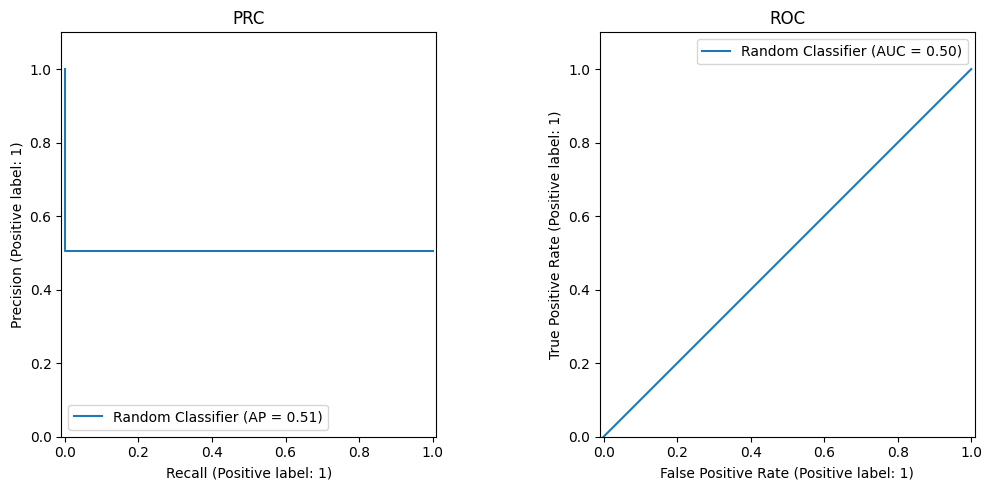

In [ ]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [ ]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(LinearSVC(), param_grid={"C": np.logspace(-4, 1 , 10)}, cv=5, scoring="average_precision")
grid_search.fit(X_train, y_train)
best_c_svm = grid_search.best_params_["C"]
best_c_svm

0.0001

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

svm, LinearSVC metrics
AUC-PR: 0.8299
AUC-ROC: 0.8451


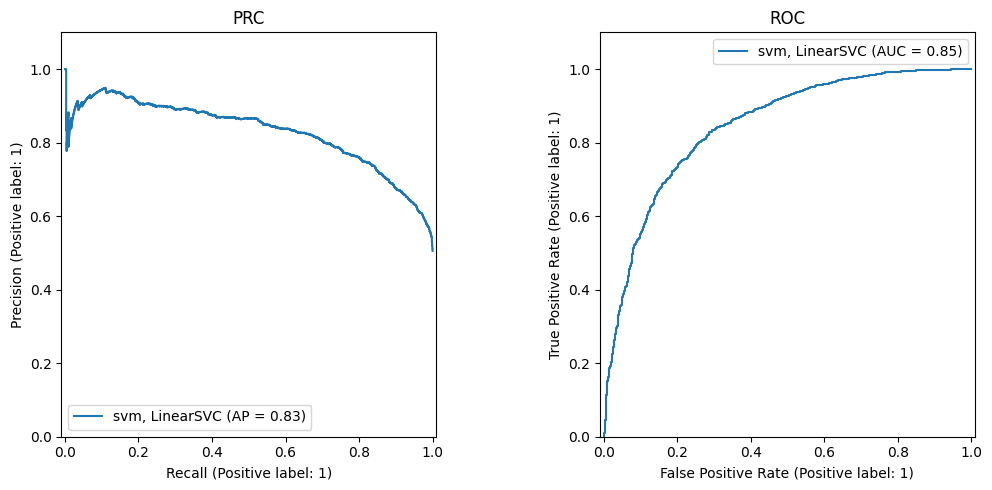

In [ ]:
y_linsvc = LinearSVC(C=best_c_svm).fit(X_train, y_train).decision_function(X_test)
depict_pr_roc(y_test, y_linsvc, 'svm, LinearSVC')

Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?
- Монотонные ли кривые? Как вы это объясните?

Ну ROC монотонна (как и следовало ожидать), вторая практически монотонна (за исключением флуктуаций в начале). При уменьшении порога падает точность, но повышается полнота (больше относим к положительному классу).

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_linsvc)
df_metrics.loc['SVM LinearSVC'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_linsvc),
      best_c_svm
]
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.0000
SVM LinearSVC,0.829657,0.845116,0.0001


Мы получили улучшение сразу по двум метрикам.

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [ ]:
from sklearn.linear_model import LogisticRegression

logreg_grid_search = GridSearchCV(
    LogisticRegression(),
    param_grid={"C": np.logspace(-4, 1, 10)},
    cv=5,
    scoring="average_precision"
)
logreg_grid_search.fit(X_train, y_train)
best_c_logreg = logreg_grid_search.best_params_["C"]
best_c_logreg

0.00035938136638046257

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000
svm, LinearSVC metrics
AUC-PR: 0.8299
AUC-ROC: 0.8451
Logistic Regression metrics
AUC-PR: 0.8348
AUC-ROC: 0.8420


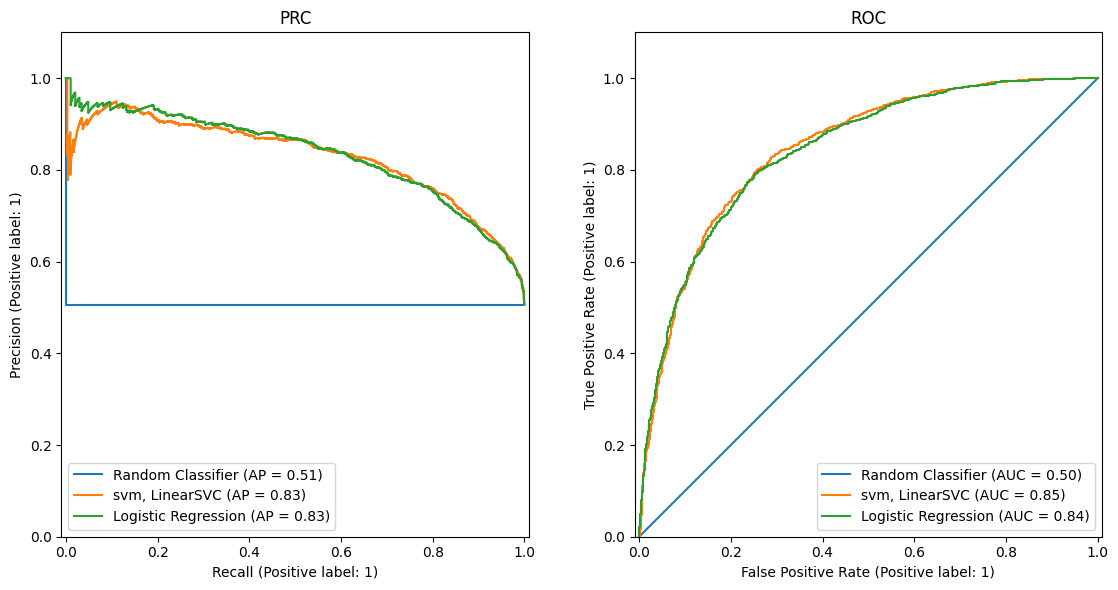

In [ ]:
y_logreg = LogisticRegression(C=best_c_logreg).fit(X_train, y_train).predict_proba(X_test)[:, 1]

_, ax = plt.subplots(1, 2, figsize=(12, 6))

depict_pr_roc(y_test, y_random, 'Random Classifier', ax=ax)
depict_pr_roc(y_test, y_linsvc, 'svm, LinearSVC', ax=ax)
depict_pr_roc(y_test, y_logreg, 'Logistic Regression', ax=ax)

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_logreg)
df_metrics.loc['Logistic Regression'] = [
    auc(recall, precision),
    roc_auc_score(y_test, y_logreg),
    best_c_logreg
]
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.000000
SVM LinearSVC,0.829657,0.845116,0.000100
Logistic Regression,0.834676,0.842038,0.000359


**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** Различий практически нет. Как видим, одна метрка чуть ниже, другая чуть выше, но в целом суть одно и то же.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [ ]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC

X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=42)

model = SVC(kernel='linear').fit(X, y)

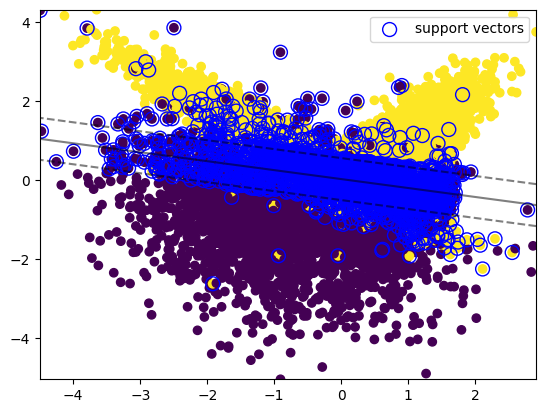

In [ ]:
def plot_svm_2D(X, y, model,  plot_support=True):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(30, 30)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y)

    # Отрисовали опорные векторы
    if plot_support:
        plt.scatter(
            model.support_vectors_[:, 0],
            model.support_vectors_[:, 1],
            label='support vectors',
            s=100,
            linewidth=1,
            edgecolor="blue",
            facecolors='none'
        )

    plt.legend()

plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** те, что на границе между классами (ну еще в другом классе)

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [ ]:
model = LogisticRegression(C=best_c_logreg).fit(X_train, y_train)

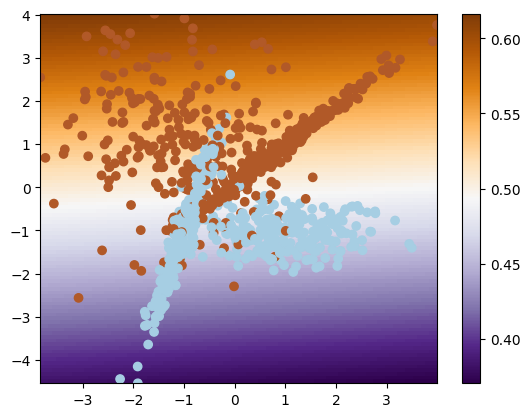

In [ ]:
def plot_logreg_2D(X, y, model):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:,1]
    Z = Z.reshape((xx.shape[0], -1)).T

    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        cmap=plt.cm.PuOr_r
    )

    #Отрисовали выборку
    plt.scatter(
        X[:, 0], X[:, 1], c=y,
        cmap=plt.cm.Paired
    )

    plt.colorbar(image)

plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** Белая прямая по горизонтали. Не уверена, потому и не окрасили

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [ ]:
def plot_calibration_curve(y_test, preds, ax=None):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    if ax is None:
        plt.figure(figsize=(6,6))
        plt.plot(bin_middle_points, bin_real_ratios)
        plt.ylim([-0.05, 1.05])
        plt.grid()
        return
    ax.plot(bin_middle_points, bin_real_ratios)
    ax.set_ylim([-0.05, 1.05])
    ax.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [ ]:
X, y = make_classification(n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

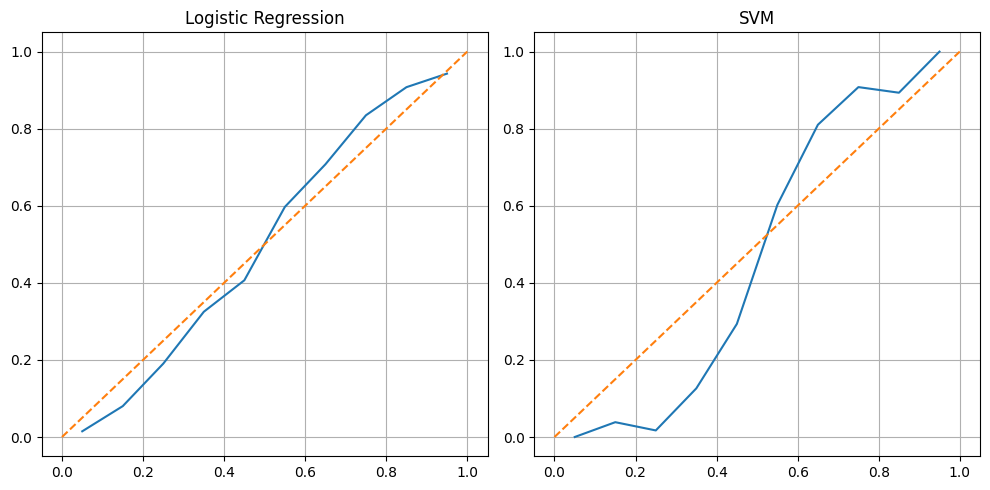

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

y_logreg = LogisticRegression(C=best_c_logreg).fit(X_train, y_train).predict_proba(X_test)[:,1]
plot_calibration_curve(y_test, y_logreg, ax=ax[0])
ax[0].plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), '--')
ax[0].set_title("Logistic Regression")

y_linsvc = LinearSVC(C=best_c_svm).fit(X_train, y_train).decision_function(X_test)
plot_calibration_curve(y_test, (y_linsvc - np.min(y_linsvc)) / (np.max(y_linsvc) - np.min(y_linsvc)), ax=ax[1])
ax[1].plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), '--')
ax[1].set_title("SVM")

plt.tight_layout()
plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** Это видно из колебаний от диагонали, т.е. лог рег лучше откалиброван.

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [ ]:
from sklearn.metrics import log_loss, brier_score_loss

logloss_logreg = log_loss(y_test, y_logreg)
brier_logreg = brier_score_loss(y_test, y_logreg)

logloss_svm = log_loss(y_test, (y_linsvc - np.min(y_linsvc)) / (np.max(y_linsvc) - np.min(y_linsvc)))
brier_svm = brier_score_loss(y_test, (y_linsvc - np.min(y_linsvc)) / (np.max(y_linsvc) - np.min(y_linsvc)))

print(f"Logistic Regression - LogLoss: {logloss_logreg:.4f}, BrierScore: {brier_logreg:.4f}")
print(f"SVM - LogLoss: {logloss_svm:.4f}, BrierScore: {brier_svm:.4f}")


Logistic Regression - LogLoss: 0.5018, BrierScore: 0.1651
SVM - LogLoss: 0.5585, BrierScore: 0.1863


По обеим метрикам выигрывает лог лосс.

Изучите распределение ответов классификаторов при помощи гистограмм

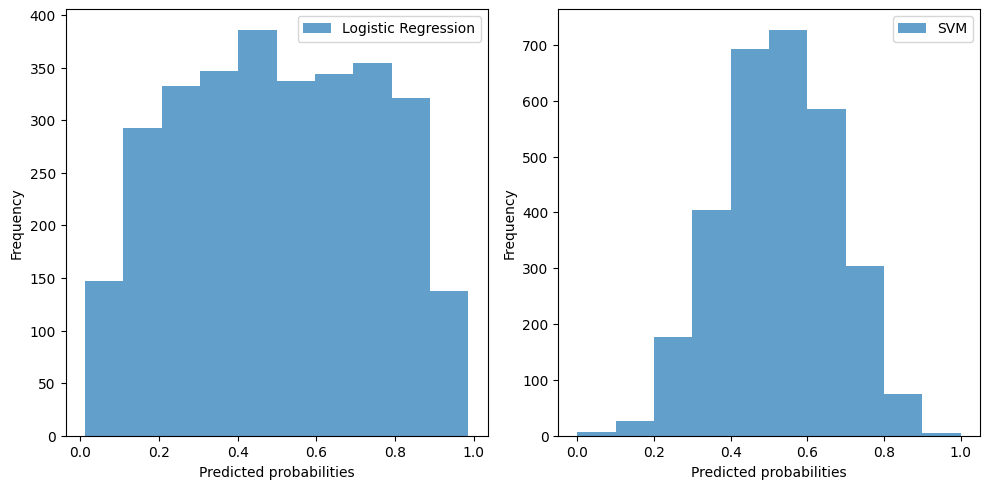

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(y_logreg, bins=10, alpha=0.7, label="Logistic Regression")
plt.xlabel("Predicted probabilities")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist((y_linsvc - np.min(y_linsvc)) / (np.max(y_linsvc) - np.min(y_linsvc)), bins=10, alpha=0.7, label="SVM")
plt.xlabel("Predicted probabilities")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()


**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** У лог рега график более равномерный, т.к. мы предсказываем вероятности. У свм мохож на нормальное, т.к. мы производим перенормировку, но сам свм он же про расстояния, а не вероятности, потому получается какаяя-то ерунда.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

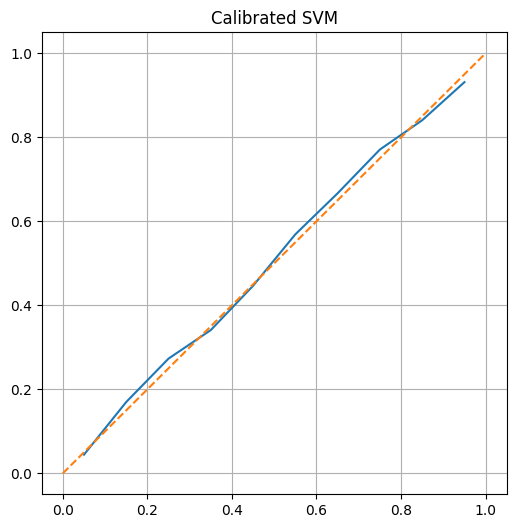

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

model = SVC(kernel='linear', C=best_c_svm).fit(X_train, y_train)
calibrated_svm = CalibratedClassifierCV(model, cv='prefit')
calibrated_svm.fit(X_train, y_train)

y_cal = calibrated_svm.predict_proba(X_test)[:,1]
plot_calibration_curve(y_test, y_cal)
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), '--')
plt.title("Calibrated SVM")
plt.show()

**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** Стало намного лучше (если вместо базового sigmoid поставить isotonic, не совсем так гладео получаестя, но так все ок)

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [ ]:
# your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [189]:
import kagglehub

path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

In [190]:
# Прочитаем датасет
data = pd.read_csv("bike_buyers.csv")

# Заменим пропуски категориальных переменных
categorical_columns = data.select_dtypes(include='object').columns
data[categorical_columns] = data[categorical_columns].fillna('undefined')

# Отделим X и y
X = data.drop(columns=['Purchased Bike'])
y = (data['Purchased Bike'] == 'Yes').astype('int64')

# Разделим на категориальные признаки и числовые
X_numerical = X.select_dtypes(include=['int64', 'float64'])
X_categorical = X.select_dtypes(include='object')

В начале поработаем только с категориальными признаками

In [191]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [192]:
from sklearn.preprocessing import OrdinalEncoder
import time

ordinal_encoder = OrdinalEncoder()
start_time = time.time()

X_train_ordinal = ordinal_encoder.fit_transform(X_train)
X_test_ordinal = ordinal_encoder.transform(X_test)

logreg = LogisticRegression().fit(X_train_ordinal, y_train)

ordinal_time = time.time() - start_time

y_pred_ordinal = logreg.predict_proba(X_test_ordinal)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_ordinal)

print(f"AUC-PR: {auc(recall, precision):.4f}")
print(f"Time: {ordinal_time:.4f}")


AUC-PR: 0.5793
Time: 0.0144


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [193]:
from sklearn.preprocessing import OneHotEncoder
import time

onehot_encoder  = OneHotEncoder()
start_time = time.time()

X_train_ordinal = onehot_encoder.fit_transform(X_train)
X_test_ordinal = onehot_encoder.transform(X_test)

logreg = LogisticRegression().fit(X_train_ordinal, y_train)

ordinal_time = time.time() - start_time

y_pred_ordinal = logreg.predict_proba(X_test_ordinal)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_ordinal)

print(f"AUC-PR: {auc(recall, precision):.4f}")
print(f"Time: {ordinal_time:.4f}")


AUC-PR: 0.6615
Time: 0.0262


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [194]:
start_time = time.time()

train_encoded = X_train.copy()
test_encoded = X_test.copy()
for col in X_train.columns:
    means = y_train.groupby(X_train[col]).mean()
    train_encoded[col] = X_train[col].map(means)
    test_encoded[col] = X_test[col].map(means).fillna(means.mean())

logreg = LogisticRegression().fit(train_encoded, y_train)

ordinal_time = time.time() - start_time

y_pred_ordinal = logreg.predict_proba(test_encoded)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_ordinal)

print(f"AUC-PR: {auc(recall, precision):.4f}")
print(f"Time: {ordinal_time:.4f}")

AUC-PR: 0.6527
Time: 0.0457


Учимся в среднем столько же, сколько и OneHot (может чуть быстрееее), по качеству так же

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [195]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns):
        self.categorical_columns = categorical_columns
        self.encodings = {}

    def fit(self, X, y):
        for col in self.categorical_columns:
            self.encodings[col] = y.groupby(X[col]).mean()
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for col in self.categorical_columns:
            X_transformed[col] = X[col].map(self.encodings[col])
        return X_transformed

In [196]:
start_time = time.time()

encoder = MeanTargetEncoder(X_train.columns)
train_encoded = encoder.fit_transform(X_train, y_train)
test_encoded = encoder.transform(X_test)

logreg = LogisticRegression().fit(train_encoded, y_train)

ordinal_time = time.time() - start_time

y_pred_ordinal = logreg.predict_proba(test_encoded)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_ordinal)

print(f"AUC-PR: {auc(recall, precision):.4f}")
print(f"Time: {ordinal_time:.4f}")

AUC-PR: 0.6527
Time: 0.0253


_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [197]:
class MeanTargetEncoderWithNoise(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns, noise_std=0.01):
        self.categorical_columns = categorical_columns
        self.noise_std = noise_std
        self.encodings = {}

    def fit(self, X, y):
        self.encodings = {}
        for col in self.categorical_columns:
            means = y.groupby(X[col]).mean()
            noise = np.random.normal(0, self.noise_std, size=means.shape)
            self.encodings[col] = means + noise
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for col in self.categorical_columns:
            X_transformed[col] = X[col].map(self.encodings[col]).fillna(self.encodings[col].mean())
        return X_transformed

In [198]:
start_time = time.time()

encoder = MeanTargetEncoderWithNoise(X_train.columns)
train_encoded = encoder.fit_transform(X_train, y_train)
test_encoded = encoder.transform(X_test)

logreg = LogisticRegression().fit(train_encoded, y_train)

ordinal_time = time.time() - start_time

y_pred_ordinal = logreg.predict_proba(test_encoded)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_ordinal)

print(f"AUC-PR: {auc(recall, precision):.4f}")
print(f"Time: {ordinal_time:.4f}")

AUC-PR: 0.6694
Time: 0.0272


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Стало совсем чут лучше (если взять больше шума, то станет плохо). Ковариация билинейна, а потому добавление шума как сохраняло, так и сохранит зависимоть

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [199]:
from sklearn.model_selection import KFold

class MeanTargetEncoderWithKFold(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns, n_splits=5, noise_std=0.01):
        self.categorical_columns = categorical_columns
        self.n_splits = n_splits
        self.noise_std = noise_std
        self.encodings = {}

    def fit(self, X, y):
        self.encodings = {}
        kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        for col in self.categorical_columns:
            self.encodings[col] = {}
            for train_index, val_index in kf.split(X):
                X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                y_train, y_val = y.iloc[train_index], y.iloc[val_index]

                means = y_train.groupby(X_train[col]).mean()
                noise = np.random.normal(0, self.noise_std, size=means.shape)
                self.encodings[col].update((k, v + noise[i]) for i, (k, v) in enumerate(means.items()))

        return self

    def transform(self, X):
        X_transformed = X.copy()
        for col in self.categorical_columns:
            X_transformed[col] = X_transformed[col].map(self.encodings[col])
        return X_transformed

In [200]:
start_time = time.time()

encoder = MeanTargetEncoderWithKFold(X_train.columns)
train_encoded = encoder.fit_transform(X_train, y_train)
test_encoded = encoder.transform(X_test)

logreg = LogisticRegression().fit(train_encoded, y_train)

ordinal_time = time.time() - start_time

y_pred_ordinal = logreg.predict_proba(test_encoded)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_ordinal)

print(f"AUC-PR: {auc(recall, precision):.4f}")
print(f"Time: {ordinal_time:.4f}")

AUC-PR: 0.6665
Time: 0.1029


#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times \text{global_mean}}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $\text{global_mean}$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [201]:
class SmoothedMeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns, smoothing=10):
        self.categorical_columns = categorical_columns
        self.smoothing = smoothing
        self.encodings = {}
        self.global_mean = None

    def fit(self, X, y):
        self.global_mean = y.mean()
        self.encodings = {}
        for col in self.categorical_columns:
            means = y.groupby(X[col]).sum()
            length = y.groupby(X[col]).size()
            self.encodings[col] = ((means + self.smoothing * np.mean(y_train)) /
                                   (length + self.smoothing))
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for col in self.categorical_columns:
            X_transformed[col] = X[col].map(self.encodings[col])

        return X_transformed

In [202]:
start_time = time.time()

encoder = SmoothedMeanTargetEncoder(X_train.columns).fit(X_train, y_train)
train_encoded = encoder.transform(X_train)
test_encoded = encoder.transform(X_test)

logreg = LogisticRegression().fit(train_encoded, y_train)

ordinal_time = time.time() - start_time

y_pred_ordinal = logreg.predict_proba(test_encoded)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_ordinal)

print(f"AUC-PR: {auc(recall, precision):.4f}")
print(f"Time: {ordinal_time:.4f}")

AUC-PR: 0.6690
Time: 0.0455


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных



In [ ]:
X_numerical.fillna(X_numerical.median(), inplace=True)

In [ ]:
X_numerical.nunique().sum()

1080

In [ ]:
X_numerical = X_numerical.drop(columns=['ID'])

In [ ]:
X_numerical.nunique().sum()

80

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [ ]:
X_trainn, X_testn, y_trainn, y_testn = train_test_split(X_numerical, y, test_size=0.25, random_state=777, stratify=y)

In [ ]:
X_train_combined = pd.concat([X_train, X_trainn], axis=1)
X_test_combined = pd.concat([X_test, X_testn], axis=1)

In [ ]:
X_train_combined.head()

,Marital Status,Gender,Education,Occupation,Home Owner,Commute Distance,Region,Income,Children,Cars,Age
345,Married,Female,Bachelors,Clerical,Yes,0-1 Miles,Europe,20000.0,1.0,0.0,50.0
540,Single,Female,Graduate Degree,Management,Yes,1-2 Miles,North America,70000.0,3.0,2.0,52.0
110,Single,Female,Partial College,Manual,No,0-1 Miles,Europe,60000.0,1.0,0.0,46.0
902,Single,Male,Bachelors,Skilled Manual,Yes,2-5 Miles,North America,80000.0,3.0,0.0,40.0
15,Single,Female,High School,Manual,Yes,0-1 Miles,Europe,10000.0,2.0,1.0,38.0


In [ ]:
def computer(features) -> None:
    start_time = time.time()

    encoder = SmoothedMeanTargetEncoder(features).fit(X_train_combined, y_train)
    train_encoded = encoder.transform(X_train_combined)
    test_encoded = encoder.transform(X_test_combined)

    logreg = LogisticRegression(max_iter=300).fit(train_encoded, y_train)

    ordinal_time = time.time() - start_time

    y_pred_ordinal = logreg.predict_proba(test_encoded)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_ordinal)
    print
    print(f"AUC-PR: {auc(recall, precision):.4f}")
    print(f"Time: {ordinal_time:.4f}")

In [ ]:
import itertools
import warnings
warnings.filterwarnings('ignore')

for i in range(len(X_numerical.columns) + 1):
    for subset in itertools.combinations(X_numerical.columns, i):
        print(*subset)
        computer(list(X_train.columns) + list(subset))
        print("-------------")
warnings.filterwarnings('always')


AUC-PR: 0.6740
Time: 0.4382
-------------
Income
AUC-PR: 0.6776
Time: 0.1461
-------------
Children
AUC-PR: 0.6943
Time: 0.1917
-------------
Cars
AUC-PR: 0.6895
Time: 0.2589
-------------
Age
AUC-PR: 0.6997
Time: 0.2796
-------------
Income Children
AUC-PR: 0.6808
Time: 0.1121
-------------
Income Cars
AUC-PR: 0.6862
Time: 0.1537
-------------
Income Age
AUC-PR: 0.6825
Time: 0.1087
-------------
Children Cars
AUC-PR: 0.7105
Time: 0.2010
-------------
Children Age
AUC-PR: 0.6925
Time: 0.2413
-------------
Cars Age
AUC-PR: 0.6744
Time: 0.2641
-------------
Income Children Cars
AUC-PR: 0.6876
Time: 0.1375
-------------
Income Children Age
AUC-PR: 0.6807
Time: 0.0961
-------------
Income Cars Age
AUC-PR: 0.6710
Time: 0.1239
-------------
Children Cars Age
AUC-PR: 0.6672
Time: 0.1139
-------------
Income Children Cars Age
AUC-PR: 0.6675
Time: 0.0420
-------------


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__  К очевидным плюсам можн отнести легковесность, т.к. мы не плодим уйму новых признаков, качество на многих наборах лучше чем Ohe. А вот проблемой может быть переобучение. Я бы не сказал, что какие-то из предложенных методов реально решают эту проблему (в конце концов, это инжененрная задача)

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2024-11-27 20:32:21--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data.1’

adult.data.1            [  <=>               ]   3.79M  8.82MB/s    in 0.4s    

2024-11-27 20:32:22 (8.82 MB/s) - ‘adult.data.1’ saved [3974305]



In [ ]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
4299,20,?,124242,Some-college,10,Never-married,?,Own-child,White,Female,0,0,40,United-States,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [ ]:
X = df.drop(columns=['income'])
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [ ]:
categorical_columns = X.select_dtypes(include='object').columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
numerical_columns

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

onehot_encoder = OneHotEncoder(sparse_output=False)
X_train_encoded = onehot_encoder.fit_transform(X_train[categorical_columns])

print(f"Before {X_train.shape[1]} features")
print(f"After {X_train_encoded.shape[1]} features")

Before 14 features
After 102 features


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [ ]:
from scipy.sparse import hstack
import warnings
warnings.filterwarnings('ignore')

onehot_encoder = OneHotEncoder()
X_train_cat_encoded = onehot_encoder.fit_transform(X_train[categorical_columns])
X_test_cat_encoded = onehot_encoder.transform(X_test[categorical_columns])

#use it later
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train[numerical_columns])
X_test_num_scaled = scaler.transform(X_test[numerical_columns])

train_x = hstack([X_train_cat_encoded, X_train[numerical_columns]])
test_x = hstack([X_test_cat_encoded, X_test[numerical_columns]])

logreg = LogisticRegression().fit(train_x, y_train)

y_combined = logreg.predict_proba(test_x)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_combined)

print(f"AUC-PR: {auc(recall, precision):.4f}")


AUC-PR: 0.4559


Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

In [ ]:
y_old = y_train

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_x, y_train, test_size=0.25, random_state=777, stratify=y_train)

Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



Условие сформулировано очень глупо, но раз говорят, что надо на валидации, я просто еще раз обучу модель, срежу признаки, а затем проверю качество.

In [ ]:
logreg = LogisticRegression().fit(X_train, y_train)

y_combined = logreg.predict_proba(X_val)[:, 1]
precision, recall, _ = precision_recall_curve(y_val, y_combined)

print(f"AUC-PR: {auc(recall, precision):.4f}")

AUC-PR: 0.4670


In [ ]:
import time
start_time = time.time()

feature_importances = np.abs(logreg.coef_[0])
top_40_indices = np.argsort(feature_importances)[::-1][:40]

train_x_selected = X_train[:, top_40_indices]
val_x_selected = X_val[:, top_40_indices]

ordinal_time = time.time() - start_time

logreg = LogisticRegression().fit(train_x_selected, y_train)
y_val_pred = logreg.predict_proba(val_x_selected)[:, 1]
precision, recall, _ = precision_recall_curve(y_val, y_val_pred)

print(f"AUC-PR: {auc(recall, precision):.4f}")
print(f"Time: {ordinal_time:.4f}")

AUC-PR: 0.6864
Time: 0.0120


Изменилось ли качество? Как?

Качество существенно возрасло.

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [ ]:
# now we use what we normalized before
train_x = hstack([X_train_cat_encoded, X_train_num_scaled])
test_x = hstack([X_test_cat_encoded, X_test_num_scaled])
X_train, X_val, y_train, y_val = train_test_split(train_x, y_old, test_size=0.25, random_state=777, stratify=y_old)

In [ ]:
logreg = LogisticRegression().fit(X_train, y_train)

y_combined = logreg.predict_proba(X_val)[:, 1]
precision, recall, _ = precision_recall_curve(y_val, y_combined)

print(f"AUC-PR old: {auc(recall, precision):.4f}")

start_time = time.time()

feature_importances = np.abs(logreg.coef_[0])
top_40_indices_scale = np.argsort(feature_importances)[::-1][:40]

train_x_selected = X_train[:, top_40_indices_scale]
val_x_selected = X_val[:, top_40_indices_scale]

ordinal_time = time.time() - start_time

logreg = LogisticRegression().fit(train_x_selected, y_train)
y_val_pred = logreg.predict_proba(val_x_selected)[:, 1]
precision, recall, _ = precision_recall_curve(y_val, y_val_pred)

print(f"AUC-PR: {auc(recall, precision):.4f}")
print(f"Time: {ordinal_time:.4f}")
print(top_40_indices_scale)

AUC-PR old: 0.7648
AUC-PR: 0.7381
Time: 0.0210
[105  26  27  41  64  29  37  50  52  84  30  58  36  40  93  61  49 104
  28  62  71  82  66  45  43  25  22  65  90  96   8  53   1  16  83  12
  70  85  42  31]


Видим, что после нашей нормировки оставлять лишь 40 было лишним

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [ ]:
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [ ]:
logreg = LogisticRegression().fit(X_train_scaled, y_train)

y_combined = logreg.predict_proba(X_val_scaled)[:, 1]
precision, recall, _ = precision_recall_curve(y_val, y_combined)

print(f"AUC-PR old: {auc(recall, precision):.4f}")

start_time = time.time()

feature_importances = np.abs(logreg.coef_[0])
top_40_indices_all = np.argsort(feature_importances)[::-1][:40]

train_x_selected = X_train_scaled[:, top_40_indices_all]
val_x_selected = X_val_scaled[:, top_40_indices_all]

ordinal_time = time.time() - start_time

logreg = LogisticRegression().fit(train_x_selected, y_train)
y_val_pred = logreg.predict_proba(val_x_selected)[:, 1]
precision, recall, _ = precision_recall_curve(y_val, y_val_pred)

print(f"AUC-PR: {auc(recall, precision):.4f}")
print(f"Time: {ordinal_time:.4f}")
print(top_40_indices_all)

AUC-PR old: 0.7637
AUC-PR: 0.7584
Time: 0.0131
[105  27  29  22 104 107  58  41  50 102  40  25 106  37  47  30  36  55
  52  20   6  86  57  99  48  10  19  64   8  38  31  49  28  88  60  21
  32   0  23   9]


Видим, что качество практически не изменилось (применяли with_mean=False, т.к. спарс-структура) разве что чуть уменьшилось. Тем не менее, модель работает сильно быстрее и мы экономимм по памяти, так что имеет смысл срезать лишние признаки. Наборы между двумя послденими пунктами изменились.

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** Чем выше модуль корреляции, тем сильнее связь между признаками. Однако не думаю, что стоит на это ориентироваться, т.к. таким бразом результат протекает в выборку.

Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора



Посчитаем с помощью втсроенной функции (данные у нас не большие, потому от материализации ни холодно, ни жарко (конечно, на больших данных я так бы не делал (как и не считал корреляцию с целевой переменной)))

In [ ]:
start_time = time.time()

correlations = pd.DataFrame(X_train.toarray()).corrwith(y_train)

top_corr_features = correlations.abs().sort_values(ascending=False).head(40).index

train_x_selected = X_train_scaled[:, top_corr_features]
val_x_selected = X_val_scaled[:, top_corr_features]

ordinal_time = time.time() - start_time

logreg = LogisticRegression().fit(train_x_selected, y_train)
y_val_pred = logreg.predict_proba(val_x_selected)[:, 1]
precision, recall, _ = precision_recall_curve(y_val, y_val_pred)

print(f"AUC-PR: {auc(recall, precision):.4f}")
print(f"Time: {ordinal_time:.4f}")
print(top_corr_features)

AUC-PR: 0.6601
Time: 1.9933
Index([101,  49,  83,  57,  55,  10,  11,  91,  74,  51,  71,  48,  67, 103,
       105,  17,  99,  82,  19,   1,  77,  73,  68,  42,   5,  84,  61,  45,
        88,   6,  96,  78,  58,  59,  85,  47,  24,  54,  62,  28],
      dtype='int64')


В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

In [ ]:
start_time = time.time()

pos = X_train[y_train == 1].toarray()
neg = X_train[y_train == 0].toarray()

n_pos = pos.shape[0]
n_neg = neg.shape[0]

mean_pos = pos.mean(axis=0)
mean_neg = neg.mean(axis=0)

var_pos = pos.var(axis=0)
var_neg = neg.var(axis=0)

t_score = np.abs(mean_pos - mean_neg) / np.sqrt((var_pos * n_pos + var_neg * n_neg) / X_train.shape[0])

top_t_features = np.argsort(np.abs(t_score))[::-1][:40]

train_x_selected = X_train_scaled[:, top_t_features]
val_x_selected = X_val_scaled[:, top_t_features]

ordinal_time = time.time() - start_time

logreg = LogisticRegression().fit(train_x_selected, y_train)
y_val_pred = logreg.predict_proba(val_x_selected)[:, 1]
precision, recall, _ = precision_recall_curve(y_val, y_val_pred)

print(f"AUC-PR: {auc(recall, precision):.4f}")
print(f"Time: {ordinal_time:.4f}")

AUC-PR: 0.7597
Time: 0.2756


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

Я знаете ли, фанат классики, а потому просто для отскалированной выборки (по всем столбцам) буду смотреть максимальный вес.

In [ ]:
start_time = time.time()

current_features = list(range(X_train_scaled.shape[1]))
step = 5
final_features_count = 40

while len(current_features) > final_features_count:
    logreg = LogisticRegression()
    logreg.fit(X_train_scaled[:, current_features], y_train)

    feature_importance = np.abs(logreg.coef_).flatten()

    to_remove = np.argsort(feature_importance)[:step]
    current_features = [f for i, f in enumerate(current_features) if i not in to_remove]


current_features.extend(to_remove[:(final_features_count - len(current_features))])

train_x_selected = X_train_scaled[:, current_features]
val_x_selected = X_val_scaled[:, current_features]

ordinal_time = time.time() - start_time

logreg = LogisticRegression().fit(train_x_selected, y_train)
y_val_pred = logreg.predict_proba(val_x_selected)[:, 1]
precision, recall, _ = precision_recall_curve(y_val, y_val_pred)

print(f"AUC-PR: {auc(recall, precision):.4f}")
print(f"Time: {ordinal_time:.4f}")
forward_features = current_features.copy()

AUC-PR: 0.7595
Time: 3.1995


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [ ]:
start_time = time.time()

available_features = set(range(X_train_scaled.shape[1]))
current_features = []
final_features_count = 40

while len(current_features) < final_features_count:
    best_auc = 0
    best_feature = None

    for feature in available_features:
        temp_features = current_features + [feature]
        logreg = LogisticRegression()
        logreg.fit(X_train_scaled[:, temp_features], y_train)

        y_pred = logreg.predict_proba(X_val_scaled[:, temp_features])[:, 1]
        precision, recall, _ = precision_recall_curve(y_val, y_pred)
        auc_pr = auc(recall, precision)

        if auc_pr > best_auc:
            best_auc = auc_pr
            best_feature = feature

    current_features.append(best_feature)
    available_features.remove(best_feature)

train_x_selected = X_train_scaled[:, current_features]
val_x_selected = X_val_scaled[:, current_features]

ordinal_time = time.time() - start_time

logreg = LogisticRegression().fit(train_x_selected, y_train)
y_val_pred = logreg.predict_proba(val_x_selected)[:, 1]
precision, recall, _ = precision_recall_curve(y_val, y_val_pred)

print(f"AUC-PR: {auc(recall, precision):.4f}")
print(f"Time: {ordinal_time:.4f}")
forward_features = current_features.copy()


AUC-PR: 0.7680
Time: 242.8691


Первый метод работает быстро, т.к. мы всего final_features_count / step раз обучаем регрессию, при этом результат получается такой же, как при использовании t статистики. Второй метод работает заметно дольше, так как обучает регресиию пордка final_features_count умноженного на число признаков. Но сильного улучшения качества не произошло.

Проведем сравнение на тесте.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

In [ ]:
onehot_encoder = OneHotEncoder()
scaler = StandardScaler(with_mean=False)
X_train_cat_encoded = onehot_encoder.fit_transform(X_train[categorical_columns])
X_test_cat_encoded = onehot_encoder.transform(X_test[categorical_columns])

train_x = scaler.fit_transform(X_train_cat_encoded)
test_x = scaler.transform(X_test_cat_encoded)

scaler1 = StandardScaler()
train_num = scaler1.fit_transform(X_train[numerical_columns])
test_num = scaler1.transform(X_test[numerical_columns])

X_train = hstack([train_x, train_num])
X_test = hstack([test_x, test_num])

In [ ]:
X_train = X_train.tocsr()
X_test = X_test.tocsr()

In [ ]:
#just with weights
train_x = X_train[:, top_40_indices_all]
test_x= X_test[:, top_40_indices_all]

logreg = LogisticRegression().fit(train_x, y_train)
y_test_pred = logreg.predict_proba(test_x)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)

print(f"AUC-PR: {auc(recall, precision):.4f}")

AUC-PR: 0.7601


In [ ]:
#correlation
train_x = X_train[:, top_corr_features]
test_x= X_test[:, top_corr_features]

logreg = LogisticRegression().fit(train_x, y_train)
y_test_pred = logreg.predict_proba(test_x)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)

print(f"AUC-PR: {auc(recall, precision):.4f}")

AUC-PR: 0.6539


In [ ]:
#t-test
train_x = X_train[:, top_t_features]
test_x= X_test[:, top_t_features]

logreg = LogisticRegression().fit(train_x, y_train)
y_test_pred = logreg.predict_proba(test_x)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)

print(f"AUC-PR: {auc(recall, precision):.4f}")

AUC-PR: 0.7620


In [ ]:
#forward
train_x = X_train[:, forward_features]
test_x= X_test[:, forward_features]

logreg = LogisticRegression().fit(train_x, y_train)
y_test_pred = logreg.predict_proba(test_x)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)

print(f"AUC-PR: {auc(recall, precision):.4f}")

AUC-PR: 0.7645


In [ ]:
#backward
train_x = X_train[:, current_features]
test_x= X_test[:, current_features]

logreg = LogisticRegression().fit(train_x, y_train)
y_test_pred = logreg.predict_proba(test_x)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)

print(f"AUC-PR: {auc(recall, precision):.4f}")

AUC-PR: 0.7645


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Преимущет=ства всех методов в экономии памяти, но потенциальная проблема с тем, что может протечь целева переменная (если только по валидации выбираем, то ок), но также проблема в обобщаемости (добавятся новыые признаки и все, поднимаем лапки). Встроенный метод, фильтрация и forward работают довольно быстро (forward при адекватном шаге), а вот backward это будто бы слишком инструмент (есть идея, что в ином случае может произойти переобучение). Как видим, на тесте лучшими являются forward, t-test и просто веса (разница между ними в тысячных).

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [120]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2024-11-28 18:26:10--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip.1’

bank-additional.zip     [   <=>              ] 434.15K   575KB/s    in 0.8s    

2024-11-28 18:26:11 (575 KB/s) - ‘bank-additional.zip.1’ saved [444572]

Archive:  bank-additional.zip
replace bank-additional/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [121]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [122]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [123]:
from collections import defaultdict
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    skf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    num_features = X.select_dtypes(include=["int64", "float64"]).columns
    cat_features = X.select_dtypes(include=["object", "category"]).columns

    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)])

    model = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(random_state=random_state))
    ])

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_pred = model.predict_proba(X_test)[:, 1]

        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        metrics.append({"AUC-PR":  auc(recall, precision)})

    return pd.DataFrame(metrics)

Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

In [124]:
results = cross_validate(X, y, random_state=777, shuffle=True)

print("Mean AUC:")
print(results.mean())
print("Dviation:")
print(results.std())
print(results)

Mean AUC:
AUC-PR    0.45221
dtype: float64
Dviation:
AUC-PR    0.028399
dtype: float64
     AUC-PR
0  0.473217
1  0.434229
2  0.441163
3  0.422255
4  0.490186


Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [125]:
def calculate_profit(y_true, y_pred, threshold, cost_call, earn_success):
    y_pred = (y_pred >= threshold).astype(int)
    cost = y_pred.sum() * cost_call

    true_positive = ((y_true == 1) & (y_pred == 1)).sum()
    revenue = true_positive * earn_success
    return revenue, cost

In [126]:
def cross_validate_with_profit(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=True,
    cost_call=2,
    earn_success=10,
    thrs=0.5
):
    metrics = []
    skf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    num_features = X.select_dtypes(include=["int64", "float64"]).columns
    cat_features = X.select_dtypes(include=["object", "category"]).columns

    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)])

    model = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(random_state=random_state))
    ])

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]

        profit, cost = calculate_profit(y_test, y_pred, thrs, cost_call, earn_success)

        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        metrics.append({"AUC-PR": auc(recall, precision), "Profit": profit - cost, "Cost": cost})

    return pd.DataFrame(metrics)

business_results = cross_validate_with_profit(X, y, n_splits=5, random_state=777, shuffle=True)

print(f"Mean profit: {business_results['Profit'].mean():.2f}")
print(f"Diviation: {business_results['Profit'].std():.2f}")
print(f"Price for calls : {business_results['Cost'].mean():.2f}")
print(f"Mean AUC-PR: {business_results['AUC-PR'].mean():.4f}")
correlation = business_results['Profit'].corr(business_results['AUC-PR'])
print(f"Correlation between Profit and AUC-PR: {correlation}")

Mean profit: 1474.00
Diviation: 157.58
Price for calls : 642.00
Mean AUC-PR: 0.4522
Correlation between Profit and AUC-PR: 0.9845105351691801


Ответы на все вопросы выше

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [127]:
def calculate_profit_with_random_revenue(y_true, y_pred, threshold, cost_call, max_revenue):
    y_pred = (y_pred > threshold).astype(int)
    cost = y_pred.sum() * cost_call

    true_positive = ((y_true == 1) & (y_pred == 1))
    random_revenue = np.random.uniform(0, max_revenue, size=y_true.shape[0])
    revenue = (true_positive * random_revenue).sum()
    return revenue - cost

In [128]:
def cross_validate_with_random_revenue(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=True,
    cost_call=2,
    max_revenue=20,
    thrs=0.5
):
    metrics = []
    skf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    num_features = X.select_dtypes(include=["int64", "float64"]).columns
    cat_features = X.select_dtypes(include=["object", "category"]).columns

    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)])

    model = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(random_state=random_state))
    ])

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]

        profit = calculate_profit_with_random_revenue(
            y_test, y_pred, thrs, cost_call, max_revenue
        )
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        metrics.append({"AUC-PR": auc(recall, precision), "Profit": profit})

    return pd.DataFrame(metrics)

business_results = cross_validate_with_random_revenue(X, y, n_splits=5, random_state=777, shuffle=True)

print(f"Mean profit: {business_results['Profit'].mean():.2f}")
print(f"Diviation: {business_results['Profit'].std():.2f}")


Mean profit: 1484.73
Diviation: 131.27


Чуть подросли, но в целом должно было получиться то же самое, т.к. матожидание равномерного 0-20 это 10.

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

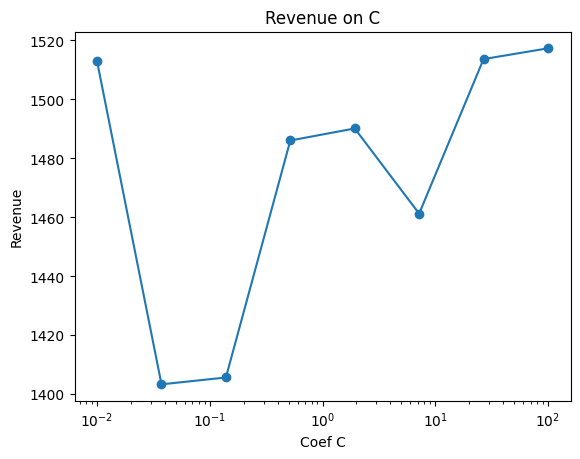

In [25]:
def searcher(X, y, C_values, n_splits=5):
    profit_means = []
    for C in C_values:
        model = LogisticRegression(C=C)
        profits = cross_validate_with_random_revenue(
            X, y, n_splits=n_splits, random_state=777
        )
        profit_means.append(profits['Profit'].mean())

    return profit_means

C_values = np.logspace(-2, 2, 8)
profit_means = searcher(X, y, C_values)

plt.plot(C_values, profit_means, marker='o')
plt.xscale("log")
plt.xlabel("Coef C")
plt.ylabel("Revenue")
plt.title("Revenue on C")
plt.show()


В целом видим, что выручка подросла на баксов 40.

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

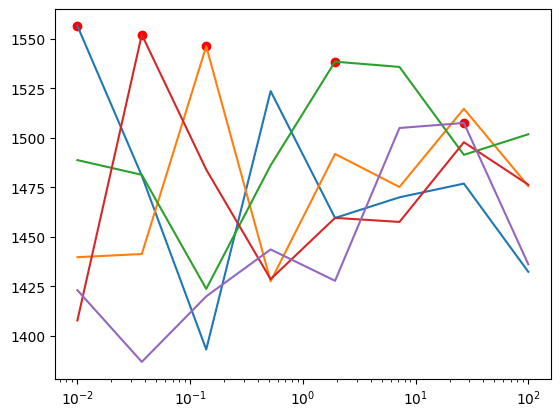

In [31]:
for _ in range(5):
    profit_means = searcher(X, y, C_values)
    plt.plot(C_values, profit_means)
    plt.xscale("log")
    profit_means_series = pd.Series(profit_means, index=C_values)

    plt.scatter(profit_means_series.idxmax(), np.max(profit_means), color='red')

Ну какой тут можно сделать вывод. Казино это.

Хотя по хорошему, видимо какой-то паттерн (коридор) намечается, но я бф не стал на нем зацикливаться.

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Я бы сказал, что скорее recall, так как мы зарабатываем на тех, кого мы правильно определили (в прочем, стоит понимать, что если точность маленькая мы обанкротимся на лишних звонках)



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

In [89]:
def cross_validate_with_threshold(X, y, n_splits=5, random_state=None, shuffle=True, cost_call=2, max_revenue=20):
    thresholds = np.arange(0, 1, 0.01)
    num_features = X.select_dtypes(include=["int64", "float64"]).columns
    cat_features = X.select_dtypes(include=["object", "category"]).columns

    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)])

    model = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(random_state=random_state))
    ])
    results = []
    for threshold in thresholds:
        metrics = []
        profits = []
        recalls = []
        skf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict_proba(X_test)[:, 1]

            prediction = (y_pred >= threshold).astype(int)
            true_positive = ((y_test == 1) & (prediction == 1))

            profit = calculate_profit_with_random_revenue(y_test, y_pred, threshold, cost_call, max_revenue)

            profits.append(profit)
            precision, recall, _ = precision_recall_curve(y_test, y_pred)
            metrics.append(auc(recall, precision))
            recalls.append(true_positive.sum() / y_test.sum())
        results.append({"AUC-PR": np.mean(metrics), "Profit": np.mean(profits), "Recall": np.mean(recalls)})
    return pd.DataFrame(results)

Постройте график зависимости прибыли от порога бинаризации. Выделите наилучший порог




Column with maximum Profit: 18
Correlation between Profit and Recall: 0.989684312617597


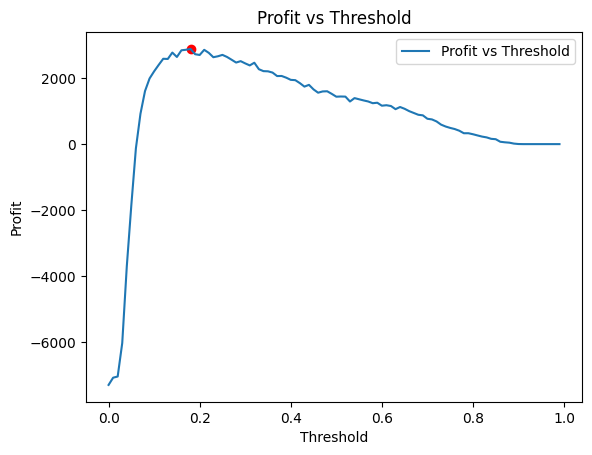

In [83]:
all_results = cross_validate_with_threshold(X, y)
thresholds = np.arange(0, 1, 0.01)
max_profit_column = all_results['Profit'].idxmax()
print(f"Column with maximum Profit: {max_profit_column}")

correlation = all_results['Profit'][max_profit_column:].corr(all_results['Recall'][max_profit_column:])
print(f"Correlation between Profit and Recall: {correlation}")
plt.plot(thresholds, all_results['Profit'], label="Profit vs Threshold")
plt.scatter(thresholds[max_profit_column], all_results['Profit'][max_profit_column], color="red")
plt.xlabel("Threshold")
plt.ylabel("Profit")
plt.title("Profit vs Threshold")
plt.legend()
plt.show()

Мы, как и ожидалось, уходим в 0 при высоком пороге, а на малых значениях мы звоним почти всем, тем самым уходя в минус (наше оптимальное значение около 0.2) (отрицательные значения, так как по началу мы зарабатываем 900 * 10, а тратим 8000 * 2)

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

In [84]:
for _ in range(3):
    all_results = cross_validate_with_threshold(X, y)
    thresholds = np.arange(0, 1, 0.01)
    max_profit_column = all_results['Profit'].idxmax()
    print(thresholds[max_profit_column])

0.21
0.2
0.21


__Ответ:__ Действительно, порог в основном в конкретной зоне. Видимо в таком случае мы совершаем достаточно звонков, чтобы заработать и не растратиться на звонки.

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

In [93]:
from scipy.stats import ttest_rel

optimized_profits = cross_validate_with_random_revenue(X, y, n_splits=5, thrs=thresholds[max_profit_column])

default_profits = cross_validate_with_random_revenue(X, y, n_splits=5)

optimized_mean = np.mean(optimized_profits["Profit"])
optimized_std = np.std(optimized_profits["Profit"])

default_mean = np.mean(default_profits["Profit"])
default_std = np.std(default_profits["Profit"])

t_stat, p_value = ttest_rel(optimized_profits["Profit"], default_profits["Profit"])

print(f"Mean revenue opt: {optimized_mean:.2f} +- {optimized_std:.2f}")
print(f"Mean revenue default: {default_mean:.2f} +- {default_std:.2f}")
print(f"T_stat: {t_stat:.2f}, p_value: {p_value:.4f}")

if p_value < 0.05:
    print("Opt is significantly better than default")
else:
    print("No significant difference")


Mean revenue opt: 2745.83 +- 154.35
Mean revenue default: 1473.13 +- 86.31
T_stat: 17.87, p_value: 0.0001
Opt is significantly better than default


# __Бонусная часть. Многоклассовая классификация__ (1.5 балла)

Как известно, некоторые задачи не ограничиваются всего лишь двумя классами. На лекции вы проходили несколько способов обобщения линейных моделей на этот случай: One-vs-Rest и One-vs-One. Ниже мы посмотрим, в чём преимущества и недостатки обоих подходов, а так же попробуем ещё один чуть более экзотический метод

#### **Задание 14. One-vs-Rest vs One-vs-One** (0.5 балла)

В качестве [датасета](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data) здесь и ниже мы будем брать очень жизненные и актуальные данные о том, доучится студент или нет, в зависимости от курсов, возраста, гендера и прочих (не)осуждаемых признаков.

In [178]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention") + "/dataset.csv"

features = ["Marital status", "Course", "Nacionality", "Gender", "Age at enrollment"]
target = "Target"

Будем смотреть только какое-то подмножество наиболее весёлых факторов. От вас по классике потребуется их преобразовать, в зависимости от того, числовые они или категориальные и **закодировать таргет чиселками!!!**

In [179]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv(path)
X = df[features]
y = df[target]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=228, shuffle=True, test_size=0.2)

In [181]:
categorical_features = ["Marital status", "Course", "Nacionality", "Gender"]
numerical_features = ["Age at enrollment"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

Ваш следующий шаг - посмотреть, каким образом в `sklearn` реализованы OvR и OvO, обучить таким образом логистическую регрессию с `max_iter=10000`, далее выбрать какую-то метрику (и её усреднение, его выбор тоже аргументируйте), и сравнить следующие параметры:
- число классификаторов
- скорость обучения
- качество модели

Также сохраните куда-нибудь предсказания вероятностей у каждой из моделей. Это можно сделать не одним способом, но возможно вам чуть с этим поможет следующий пункт


In [182]:
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import accuracy_score, f1_score

base_model = LogisticRegression(max_iter=10000, random_state=228)

ovr_model = OneVsRestClassifier(base_model)
pipeline_ovr = Pipeline([("preprocessor", preprocessor), ("classifier", ovr_model)])
pipeline_ovr.fit(X_train, y_train)
y_pred_ovr = pipeline_ovr.predict(X_test)
y_proba_ovr = pipeline_ovr.predict_proba(X_test)

ovo_model = OneVsOneClassifier(base_model)
pipeline_ovo = Pipeline([("preprocessor", preprocessor), ("classifier", ovo_model)])
pipeline_ovo.fit(X_train, y_train)
y_pred_ovo = pipeline_ovo.predict(X_test)
y_proba_ovo = pipeline_ovo.decision_function(X_test)

В многоклассовом случае довольно просто считается accuracy (на википедии еще посоветовали macro f1)

In [183]:
n_classes = len(np.unique(y))
n_classifiers_ovr = n_classes
n_classifiers_ovo = n_classes * (n_classes - 1) // 2

print(f"Number classifiers OvR: {n_classifiers_ovr}")
print(f"Number classifiers OvO: {n_classifiers_ovo}")

Number classifiers OvR: 3
Number classifiers OvO: 3


In [140]:
from time import time

start_time = time()
pipeline_ovr.fit(X_train, y_train)
time_ovr = time() - start_time

start_time = time()
pipeline_ovo.fit(X_train, y_train)
time_ovo = time() - start_time

print(f"Time OvR: {time_ovr:.2f}")
print(f"Time OvO: {time_ovo:.2f}")

Time OvR: 0.37
Time OvO: 0.38


In [162]:
print(f"OvR accuracy: {accuracy_score(y_test, y_pred_ovr)}")
print(f"OvO accuracy: {accuracy_score(y_test, y_pred_ovo)}")
print(f"OvR f1_macro: {f1_score(y_test, y_pred_ovr, average='macro')}")
print(f"OvO f1_macro: {f1_score(y_test, y_pred_ovo, average='macro')}")

OvR accuracy: 0.5638418079096045
OvO accuracy: 0.5661016949152542
OvR f1_macro: 0.397388694690007
OvO f1_macro: 0.4128961456771485


Как вы объясните полученные результаты?

__Ответ:__ У нас всего 3 класса, потому OvR не особо быстрее OvO (еще и число классификаторов у них одинаковое). По качеству почти одинаковое исполненение.

#### __Задание 15. Softmax регрессия__ (1 балл)

Однако любознательные машинисты могут задаться вопросом "А зачем нам вся эта шляпа, если у сигмоиды есть обобщение на случай многоклассовой классификации?" Если вам понравилось считать градиенты в прошлом дз, или вам нравится обучать нейросети, этот пункт для вас. Здесь мы попробуем построить одну-единственную модель, которая будет всё предсказывать, а также сравним с вариантами выше

Начнём с подсчёта лосса. Вспомним, что логистическая функция потерь это частный случай кросс-энтропии, её и будем пытаться оптимизировать.

$$
\text{CE}(X, y) = -\frac{1}{N}\sum_i \sum_k [y_i = k] \log p(x_i = k)
$$
Вероятности в данном случае будем считать при помощи софтмакса, что есть общий случай сигмоиды

$$
p(x_i) = \text{Softmax}(a(x_i)); \quad
\text{Softmax}(x)_k = \frac{e^{x_{k}}}{\sum_j e^{x_{j}}} \\
$$

Предсказание модели на одном объекта будет делаться уже при помощи матрицы весов, посклоьку выходов несколько

$$
a(x_i) = x_i\cdot W \\
$$

Ниже предлагается написать код для такой функции потерь. Если необходимо, модифицируйте шаблон по своему усмотрению (вспомогательные функции, новые аргументы, всё, что душа пожелает)

In [184]:
from typing import Iterable, Optional
from torch.nn.functional import cross_entropy
import torch

def custom_ce(
    y_pred: np.ndarray[float],
    y_true: np.ndarray[int],
) -> float:
    exp_x = np.exp(y_pred - np.max(y_pred, axis=1, keepdims=True))
    probabilities = exp_x / np.sum(exp_x, axis=1, keepdims=True)

    log_probs = np.log(probabilities[np.arange(len(y_true)), y_true])

    loss = -np.mean(log_probs)
    return loss

In [185]:
for _ in range(1000):

    n_objects = np.random.randint(1, 100)
    n_classes = np.random.randint(2, 20)
    y_pred = np.random.normal(0, 1, (n_objects, n_classes))
    y_true = np.random.randint(low=0, high=n_classes, size=(n_objects,))

    your_ce = custom_ce(y_pred, y_true) # не забудьте поправить, если меняли шаблон
    torch_ce = cross_entropy(torch.tensor(y_pred), torch.tensor(y_true))
    assert np.allclose(your_ce, torch_ce), "Что-то пошло не так"

Дальше самая интересная часть - нужно вывести производную этой функции потерь (на всякий случай уточним, что `torch` использовать нельзя, разве что для самопроверки). Полезные факты, которые вам могут пригодиться:

- в матричном виде найти производную непросто, попробуйте сперва сделать это для одного объекта, обобщить будет полегче
- логсофтмакс дифференцировать гораздо легче, чем просто софтмакс
- не забывайте про правило дифференцирования сложной функции
- поскольку веса в данном случае матрица, результат будет тоже матрица, учтите при сверке размерностей
- если вы не придумали, как преобразовать индикаторы в векторный вид, сейчас самое время

https://math.stackexchange.com/questions/2013050/log-of-softmax-function-derivative

Вообще, мы таким на DL занимались, но, как видно, градиаент от лог софтмакса по pred это просто матрица c истинными классами за вычетом матрицы вероятностей. Далее нам останется просто домножить на матрицу X по цепному правилу (когда pred по весам ищем).  При этом, мы понимаем, что все индикаторы можно прокинуть (там либо 0, либо 1, т.е. дифференцируем мы также логсофтмакс)

In [186]:
def ce_gradient(X: np.ndarray, W: np.ndarray, y: np.ndarray) -> np.ndarray[float]:
    pred = X @ W

    exp_x = np.exp(pred - np.max(pred, axis=1, keepdims=True))
    probabilities = exp_x / np.sum(exp_x, axis=1, keepdims=True)

    mask = np.zeros_like(probabilities)
    mask[np.arange(len(y)), y] = 1

    grad = X.T @ (probabilities - mask) / len(X)
    return grad

Дальше дело за малым. Вспомните (или узнайте), как делается градиентный спуск, и дополните класс софтмакс-регрессии ниже. Здесь разумнее использовать критерий останова по итерациям, но логрег из `sklearn` устроен немного хитрее. Если хотите добавить еще критерии останова, какие-то другие параметры, то пожалуйста

In [188]:
class SoftmaxRegression:

    def __init__(self, lr=1e-3, max_iter=10000):
        self.W = None
        self.max_iter = max_iter
        self.lr = lr

    def fit(self, X, y):
        n_samples, n_features = X.shape
        n_classes = np.max(y) + 1
        self.W = np.random.normal(0, 0.01, (n_features, n_classes))

        for i in range(self.max_iter):
            grad = ce_gradient(X, self.W, y)
            self.W -= self.lr * grad

    def predict(self, X, y=None):
        pred = X @ self.W
        return np.argmax(pred, axis=1)

    def predict_proba(self, X):
        pred = X @ self.W
        exp_x = np.exp(pred - np.max(pred, axis=1, keepdims=True))
        probabilities = exp_x / np.sum(exp_x, axis=1, keepdims=True)
        return probabilities

Обучите на тех же данных, что и выше, замерьте те же три параметра, плюс сравните значения кросс-энтропии для уже трёх моделей. Сравните модели между собой и выберите фаворита в данной задаче.

In [171]:
softmax_model = SoftmaxRegression(lr=0.005, max_iter=1000)
start_time = time()
softmax_model.fit(X_train.values, y_train)
time_soft = time() - start_time

y_pred_softmax = softmax_model.predict(X_test.values)
y_proba_softmax = softmax_model.predict_proba(X_test.values)

softmax_ce = custom_ce(y_proba_softmax, y_test)

ovr_ce = custom_ce(y_proba_ovr, y_test)
ovo_ce = custom_ce(y_proba_ovo, y_test)

print(f"Time: {time_soft:.2f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_softmax)}")
print(f"F1 macro: {f1_score(y_test, y_pred_softmax, average='macro')}")
print("Cross-entropy:")
print(f"OvR: {ovr_ce:.4f}, OvO: {ovo_ce:.4f}, Softmax: {softmax_ce:.4f}")


Time: 0.69
Accuracy: 0.5242937853107345
F1 macro: 0.34914743575748314
Cross-entropy:
OvR: 0.9986, OvO: 1.0183, Softmax: 1.0493


__Ответ__: Как видим, SoftMax не очень себя показал (видимо потому про него и не говрили на лекции, что совсем экзотика). В принципе, он сравним с другими методами (accuracy чуть хуже, f1 чуть лучше, кросс-энтропия худшая). Обучаение зависит от числа итераций, но больше 1000 реузльтат особо не менятеся. Задача довольно искусственная, а потому выбрать фаворита проблематично, каждый в каком-то одном показателе да лидирует. Но я бы сказал, что OvO, т.к. в среднем он выше своих конкурентов (по метрикам да и времени выполенения)

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ Овсянка, чай с пряниками